## OPTAA Clean Water Calibration Reprocessing Example
In this example I use files found in `3305-00513-00113-A_SN_138_Recovery_OPTAA-J` from Alfresco.


In [1]:
import matplotlib.pyplot as plt

## Dependencies

In [2]:
from itertools import combinations
import os
import numpy as np
import re
from scipy import interpolate
import xarray as xr

In [3]:
# Identify filepaths. A better, intuitive method could be designed for a command line tool.

post_a1_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_a01.dat"
post_a2_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_a02.dat"
post_a3_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_a03.dat"

post_c1_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_c01.dat"
post_c2_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_c02.dat"
post_c3_fp = "C:/Users/Ian/Desktop/3305-00513-00113-A_SN_138_Recovery_OPTAA-J/acs138_cal_c03.dat"

# Helper Class and Functions

In [4]:
class CalDatParser():
    
    NUM_PAT = '[+-]?[0-9]*[.]?[0-9]+' # Regex pattern for any number, positive or negative, float or int.
    
    def __init__(self, filepath: os.path.abspath, channel: str, cal_type: str, cal_iteration: int) -> None:
        self.filepath = os.path.normpath(filepath)
        self.filename = os.path.basename(self.filepath)
        self._verify_channel(channel)
        
        self.cal_type = cal_type.lower()
        if self.cal_type not in ['pre','post']:
            raise ValueError(f"{self.cal_type} is not a valid calibration type")
        
        self.cal_iteration = cal_iteration
        
        self.__read_dat()
        self.__parse_metadata()
        self.__parse_data()    
        self._check_parse()
    
    
    def __read_dat(self) -> None:
        """Import the .dat file"""

        with open(self.filepath, 'r') as file:
            self._lines = file.readlines()
            
        # Find the line that separates the sensor metadata and data collected through WetView.
        # The WetView manual says this is line 99, but we will seek out the initial acquisition line instead.
        [acquisition_start_line] = [line for line in self._lines if 'acquisition' in line]
        self._acquisition_start_idx = self._lines.index(acquisition_start_line)

        
    def __parse_metadata(self) -> None:
        """Parse each line for sensor metadata, including wavelengths, offsets, and delta_t."""
        
        metadata_lines = self._lines[:self._acquisition_start_idx] # Subset metadata lines.
        for line in metadata_lines:
            if 'WetView' in line:
                continue # Need to add
            elif 'ACS Meter' in line:
                self.sensor_type = re.findall('(.*?)\n', line)[0]
            elif 'Serial number' in line:
                self.sn_hexdec = re.findall('(.*?)\t', line)[0]
                self.sn = 'ACS' + str(int(self.sn_hexdec[-6:], 16)).zfill(3)
            elif 'structure version' in line:
                self.structure_version = int(re.findall(f'({self.NUM_PAT})\t', line)[0])
            elif 'Depth calibration' in line:
                (self.depth_cal_offset,
                 self.depth_cal_scale_factor) = [float(v) for v in re.findall(f'({self.NUM_PAT})\t', line)]
            elif 'Baud' in line:
                self.baudrate = int(re.findall(f'({self.NUM_PAT})\t', line)[0])
            elif 'Path' in line:
                self.path_length = float(re.findall(f'({self.NUM_PAT})\t', line)[0]) 
            elif 'wavelengths' in line:
                self.num_wavelengths = self.nwvls = int(re.findall(f'({self.NUM_PAT})\t', line)[0])
            elif 'number of temperature bins' in line:
                self.num_tbins = int(re.findall(f'({self.NUM_PAT})\t', line)[0])
            elif 'maxANoise' in line:
                (self.max_a_noise, self.max_c_noise, self.max_a_nonconform, self.max_c_nonconform,
                 self.max_a_difference, self.max_c_difference, self.min_a_counts,
                 self.min_c_counts, self.min_r_counts, self.max_temp_sdev,
                 self.max_depth_sdev) = [float(v) for v in re.findall(f'({self.NUM_PAT})\t', line)]

        # Parse out temperature bins.    
        temp_bin_line = [line for line in metadata_lines if '; temperature bins' in line][0]
        self.tbins = np.array(re.findall(self.NUM_PAT,temp_bin_line)).astype(float)
        
        # Parse out wavelengths and factory offsets.
        offset_lines = [line for line in metadata_lines if 'C and A offset' in line]
        wavelength_c = []
        offset_c = []
        delta_t_c = []
        wavelength_a = []
        offset_a = []
        delta_t_a = []
        for line in offset_lines:
            offsets, dc, da = line.split('\t\t')[:-1]  # The last element is the comment.
            wvlc, wvla, _, offc, offa = offsets.split('\t')
            wavelength_c.append(wvlc.replace('C',''))        
            wavelength_a.append(wvla.replace('A',''))        
            offset_c.append(offc)
            offset_a.append(offa)
            delta_t_c.append(np.array(dc.split('\t')).astype(float))
            delta_t_a.append(np.array(da.split('\t')).astype(float))
        
        self.wavelength_c = np.array(wavelength_c).astype(float)
        self.wavelength_a = np.array(wavelength_a).astype(float)
        self.offset_c = np.array(offset_c).astype(float)
        self.offset_a = np.array(offset_a).astype(float)
        self.delta_t_c = np.array(delta_t_c).astype(float)
        self.delta_t_a = np.array(delta_t_a).astype(float)
        
        # Create 1D interpolation functions.
        self.f_delta_t_c = interpolate.interp1d(self.tbins, self.delta_t_c, axis=1, assume_sorted=True, copy=False,
                                                bounds_error=False,
                                                fill_value=(self.delta_t_c[:, 1], self.delta_t_c[:, -1]))
        self.f_delta_t_a = interpolate.interp1d(self.tbins, self.delta_t_a, axis=1, assume_sorted=True, copy=False,
                                                bounds_error=False,
                                                fill_value=(self.delta_t_a[:, 1], self.delta_t_a[:, -1]))
        
        
    def __parse_data(self) -> None:
        self.acquisition_binsize = int(re.findall(f'({self.NUM_PAT})',self._lines[self._acquisition_start_idx])[0])    
        wavelengths_line = self._lines[self._acquisition_start_idx + 1]
        self._data_header_c_wvls = np.array(re.findall(f'C({self.NUM_PAT})', wavelengths_line)).astype(float)
        self._data_header_a_wvls = np.array(re.findall(f'A({self.NUM_PAT})', wavelengths_line)).astype(float)
        
        # Order: 
        #Element 0: Zero-based timestamp (ms), 
        #Element 1 to nwvls+1: 'c' values
        #Element nwvls+1 to nvwls + nwvls +1: 'a' values
        # Internal temp, filter wheel diag, pressure, external temp, dark vals (4 cols)
        
        data_lines = self._lines[self._acquisition_start_idx+2:]
        data = np.genfromtxt(data_lines)
        self.elapsed_time = data[:, 0].astype(np.int64)
        self.c_data = data[:, 1: self.nwvls + 1]
        self.a_data = data[:, self.nwvls + 1: self.nwvls + 1 + self.nwvls]
        self.internal_temperature = data[:, self.nwvls + 1 + self.nwvls]
        self.speed_diagnostic = data[:, self.nwvls + 1 + self.nwvls + 1]
        self.pressure = data[:, self.nwvls + 1 + self.nwvls + 2]
        self.external_temperature = data[:, self.nwvls + 1 + self.nwvls + 3]
        self.a_ref_dark = data[:, self.nwvls + 1 + self.nwvls + 4].astype(int)
        self.a_sig_dark = data[:, self.nwvls + 1 + self.nwvls + 5].astype(int)
        self.c_ref_dark = data[:, self.nwvls + 1 + self.nwvls + 6].astype(int)
        self.c_sig_dark = data[:, self.nwvls + 1 + self.nwvls + 7].astype(int)
 
 
    def _check_parse(self) -> bool:
        if not np.array_equal(self.wavelength_c, self._data_header_c_wvls):
            msg = 'Mismatch in parsing C wavelengths.'
            raise ValueError(msg)
        elif not np.array_equal(self.wavelength_a, self._data_header_a_wvls):
            msg = 'Mismatch in parsing A wavelengths.'
            raise ValueError(msg)
        elif self.delta_t_a.shape != (self.num_wavelengths, self.num_tbins):
            msg = 'Mismatch in shape of delta t a.'
            raise ValueError(msg)
        elif self.delta_t_c.shape != (self.num_wavelengths, self.num_tbins):
            msg = 'Mismatch in shape of delta t c.'
            raise ValueError(msg)
        else:
            return True
    
    def _verify_channel(self, channel: str) -> None:
        channel = channel.lower()
        if channel != 'a' and channel != 'c':
            msg = 'Input channel must be "a" or "c".'
            raise ValueError(msg)
        self.channel = channel
        
    def to_dict(self) -> dict:
        _ds = self.to_dataset()
        _dict = _ds.to_dict()
        return _dict


    def to_dataset(self) -> xr.Dataset:
        _ds = xr.Dataset()
        _ds = _ds.assign_coords({'elapsed_time': self.elapsed_time, 'temperature_bins': self.tbins})
        
        # Coordinate Attributes
        _ds['elapsed_time'].attrs['units'] = 'milliseconds'
        _ds['elapsed_time'].attrs['description'] = 'Milliseconds since data acquisition began.'

        _ds['temperature_bins'].attrs['units'] = 'degrees Celsius'
        _ds['temperature_bins'].attrs['description'] = 'Temperature bins used during factory calibration.'
        
        if self.channel == 'a':
            _ds = _ds.assign_coords({'wavelength_a': self.wavelength_a})
            _ds['a_w'] = (['elapsed_time', 'wavelength_a'], self.a_data)
            _ds['factory_delta_t_a'] = (['wavelength_a','temperature_bins'], self.delta_t_a)
            _ds['a_ref_dark'] = (['elapsed_time'], self.a_ref_dark)
            _ds['a_sig_dark'] = (['elapsed_time'], self.a_sig_dark)
            _ds['factory_offset_a'] = (['wavelength_a'], self.offset_a)
            
            # Absorption Coordinate and Variable Attributes
            _ds['a_w'].attrs['units'] = 'inverse meters'
            _ds['a_w'].attrs['description'] = 'Clean water absorption measurements performed during a field/user calibration.'

            _ds['factory_delta_t_a'].attrs['units'] = 'degrees Celsius'
            _ds['factory_delta_t_a'].attrs['description'] = 'Factory derived delta t a values.'

            _ds['a_ref_dark'].attrs['units'] = 'counts'
            _ds['a_ref_dark'].attrs['description'] = 'Sensor absorption reference dark values collected during data acquisition.'

            _ds['a_sig_dark'].attrs['units'] = 'counts'
            _ds['a_sig_dark'].attrs['description'] = 'Sensor absorption signal dark values collected during data acquisition.'

            _ds['factory_offset_a'].attrs['units'] = 'inverse meters'
            _ds['factory_offset_a'].attrs['description'] = 'Factory derived offset values.'

            _ds.attrs['max_a_noise'] = self.max_a_noise
            _ds.attrs['max_a_nonconform'] = self.max_a_nonconform
            _ds.attrs['max_a_difference'] = self.max_a_difference
            _ds.attrs['min_a_counts'] = self.min_a_counts

        elif self.channel == 'c':
            _ds = _ds.assign_coords({'wavelength_c': self.wavelength_c})
            _ds['c_w'] = (['elapsed_time', 'wavelength_c'], self.c_data)
            _ds['factory_delta_t_c'] = (['wavelength_c','temperature_bins'], self.delta_t_c)
            _ds['c_ref_dark'] = (['elapsed_time'], self.c_ref_dark)
            _ds['c_sig_dark'] = (['elapsed_time'], self.c_sig_dark)
            _ds['factory_offset_c'] = (['wavelength_c'], self.offset_c)

            # Absorption Coordinate and Variable Attributes
            _ds['c_w'].attrs['units'] = 'inverse meters'
            _ds['c_w'].attrs['description'] = 'Clean water absorption measurements performed during a field/user calibration.'

            _ds['factory_delta_t_c'].attrs['units'] = 'degrees Celsius'
            _ds['factory_delta_t_c'].attrs['description'] = 'Factory derived delta t a values.'

            _ds['c_ref_dark'].attrs['units'] = 'counts'
            _ds['c_ref_dark'].attrs['description'] = 'Sensor absorption reference dark values collected during data acquisition.'

            _ds['c_sig_dark'].attrs['units'] = 'counts'
            _ds['c_sig_dark'].attrs['description'] = 'Sensor absorption signal dark values collected during data acquisition.'

            _ds['factory_offset_c'].attrs['units'] = 'inverse meters'
            _ds['factory_offset_c'].attrs['description'] = 'Factory derived offset values.'

            _ds.attrs['max_c_noise'] = self.max_c_noise
            _ds.attrs['max_c_nonconform'] = self.max_c_nonconform
            _ds.attrs['max_c_difference'] = self.max_c_difference
            _ds.attrs['min_c_counts'] = self.min_c_counts
            
        _ds['internal_temperature'] = (['elapsed_time'], self.internal_temperature)
        _ds['internal_temperature'].attrs['units'] = 'degrees Celsius'
        _ds['internal_temperature'].attrs['description'] = 'Temperature of the thermistor internal of the sensor housing.'
        
        _ds['external_temperature'] = (['elapsed_time'], self.external_temperature)
        _ds['external_temperature'].attrs['units'] = 'degrees Celsius'
        _ds['external_temperature'].attrs['description'] = 'Temperature of the thermistor external of the sensor housing.'
    
    
        _ds['speed_diagnostic'] = (['elapsed_time'], self.speed_diagnostic)
        _ds['speed_diagnostic'].attrs['units'] = ''
        _ds['speed_diagnostic'].attrs['description'] = 'Filter wheel speed diagnostic information.'

        _ds['pressure'] = (['elapsed_time'], self.pressure)
        _ds['pressure'].attrs['units'] = 'counts'
        _ds['pressure'].attrs['description'] = 'Pressure data for ACS sensors equipped with pressure sensors (deprecated}.'
 
        
        # Assign dataset level attributes.
        _ds.attrs['serial_number'] = self.sn
        _ds.attrs['serial_number_hexdec'] = self.sn_hexdec
        _ds.attrs['structure_version'] = self.structure_version
        _ds.attrs['num_wavelengths'] = self.num_wavelengths
        _ds.attrs['filepath'] = self.filepath
        _ds.attrs['filename'] = self.filename
        _ds.attrs['calibration_channel'] = self.channel
        _ds.attrs['num_tbins'] = self.num_tbins
        _ds.attrs['sensor_type'] = self.sensor_type
        _ds.attrs['acquisition_binsize'] = self.acquisition_binsize
        _ds.attrs['path_length'] = self.path_length
        _ds.attrs['baudrate'] = self.baudrate
        _ds.attrs['min_r_counts'] = self.min_r_counts
        _ds.attrs['max_temp_sdev'] = self.max_temp_sdev
        _ds.attrs['max_depth_sdev'] = self.max_depth_sdev
        _ds.attrs['depth_cal_offset'] = self.depth_cal_offset
        _ds.attrs['depth_cal_scale_factor'] = self.depth_cal_scale_factor
        _ds.attrs['calibration_type'] = self.cal_type 
        _ds.attrs['calibration_run_iteration'] = self.cal_iteration
        return _ds


def compute_run_offset(w: xr.DataArray, lower_quantile = 0.05, upper_quantile = 0.95) -> xr.DataArray:
    qw = w.quantile([lower_quantile,upper_quantile], dim = 'elapsed_time') # Obtain the lower and upper quantiles.
    lower = np.array(qw.sel(quantile=lower_quantile)) # Parse out the quantile by wavelength.
    upper = np.array(qw.sel(quantile=upper_quantile))
    _w = w.where((w < upper) & (w > lower), np.nan) # If outside the quantile, NaN it.
    _w = _w.mean(dim = 'elapsed_time') # Compute the mean at each wavelength.
    return _w


def identify_best_cals(input_datasets: list, max_diff = 0.002):
    """
    A super convoluted AF method for identifying the two closest cal runs.
    
    :param input_datasets: 
    :param max_diff: 
    :return: 
    """
    if len(input_datasets) == 2:
        ds1, ds2 = input_datasets
        return ds1, ds2
    runs = {}
    run_num = 0
    for i,j in combinations(input_datasets, r = 2):
        closeness = abs(i.clean_offset - j.clean_offset) <= max_diff
        num_close_values = int(closeness.sum())
        runs[run_num] = {'file_1': i.filename, 'file_2': j.filename, 'num_close': num_close_values}
        run_num +=1
    max_close = max(v['num_close'] for v in runs.values())
    for run, run_data in runs.items():
        if run_data['num_close'] == max_close:
            break    
    ds1 = [_ds for _ds in input_datasets if _ds.filename == run_data['file_1']][0]
    ds2 = [_ds for _ds in input_datasets if _ds.filename == run_data['file_1']][0]
    return ds1, ds2


def compute_mean_offset(ds1_cw_offset, ds2_cw_offset):
    mean_offset = (ds1_cw_offset + ds2_cw_offset)/2
    return mean_offset

# Processing Steps

In [5]:
post_a1 = CalDatParser(post_a1_fp, channel = 'a', cal_type = 'post', cal_iteration=1).to_dataset()
post_a2 = CalDatParser(post_a2_fp, channel='a', cal_type = 'post', cal_iteration=2).to_dataset()
post_a3 = CalDatParser(post_a3_fp, channel = 'a', cal_type = 'post', cal_iteration=3).to_dataset()
post_a_cals = [post_a1, post_a2, post_a3]

post_c1 = CalDatParser(post_c1_fp, channel = 'c', cal_type = 'post', cal_iteration=1).to_dataset()
post_c2 = CalDatParser(post_c2_fp, channel='c', cal_type = 'post', cal_iteration=2).to_dataset()
post_c3 = CalDatParser(post_c3_fp, channel = 'c', cal_type = 'post', cal_iteration=3).to_dataset()
post_c_cals = [post_c1, post_c2, post_c3]

In [6]:
# Pre computation dataset.
post_c1

<xarray.Dataset>
Dimensions:               (elapsed_time: 133, temperature_bins: 36,
                           wavelength_c: 86)
Coordinates:
  * elapsed_time          (elapsed_time) int64 0 250 500 ... 32500 32750 33000
  * temperature_bins      (temperature_bins) float64 0.584 1.41 ... 34.48 35.0
  * wavelength_c          (wavelength_c) float64 399.4 403.2 ... 746.4 749.7
Data variables:
    c_w                   (elapsed_time, wavelength_c) float64 -0.08088 ... 0...
    factory_delta_t_c     (wavelength_c, temperature_bins) float64 -0.01913 ....
    c_ref_dark            (elapsed_time) int32 476 476 476 476 ... 476 476 476
    c_sig_dark            (elapsed_time) int32 717 717 717 717 ... 717 717 717
    factory_offset_c      (wavelength_c) float64 0.9356 0.9792 ... -1.275 -1.315
    internal_temperature  (elapsed_time) float64 22.17 22.16 ... 22.18 22.18
    external_temperature  (elapsed_time) float64 22.11 22.11 ... 22.12 22.13
    speed_diagnostic      (elapsed_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pressure              (elapsed_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes: (12/23)
    max_c_noise:                0.0
    max_c_nonconform:           0.0
    max_c_difference:           0.0
    min_c_counts:               0.0
    serial_number:              ACS138
    serial_number_hexdec:       5300008A
    ...                         ...
    max_temp_sdev:              0.0
    max_depth_sdev:             0.0
    depth_cal_offset:           0.0
    depth_cal_scale_factor:     0.0
    calibration_type:           post
    calibration_run_iteration:  1

In [7]:
# Compute the offsets for the given cal run and assign to the corresponding dataset.
post_a1['clean_offset'] = compute_run_offset(post_a1.a_w)
post_a2['clean_offset'] = compute_run_offset(post_a2.a_w)
post_a3['clean_offset'] = compute_run_offset(post_a3.a_w)

post_c1['clean_offset'] = compute_run_offset(post_c1.c_w)
post_c2['clean_offset'] = compute_run_offset(post_c2.c_w)
post_c3['clean_offset'] = compute_run_offset(post_c3.c_w)

In [8]:
#Cal run offset computation
post_c1.clean_offset

<xarray.DataArray 'clean_offset' (wavelength_c: 86)>
array([-0.07867571, -0.07367815, -0.07190446, -0.06967896, -0.06231325,
       -0.06260263, -0.05993105, -0.05622017, -0.05696798, -0.05251195,
       -0.05032296, -0.05054527, -0.04694853, -0.04859137, -0.04650845,
       -0.04508148, -0.04531412, -0.04510269, -0.04358398, -0.04477914,
       -0.04307728, -0.04251559, -0.04293351, -0.04338629, -0.04291218,
       -0.04181212, -0.04233819, -0.04205263, -0.04288136, -0.04152602,
       -0.04095759, -0.04312746, -0.04234136, -0.04111395, -0.04356222,
       -0.04182092, -0.04226059, -0.04060496, -0.04105933, -0.04158137,
       -0.04265301, -0.0439127 , -0.04207803, -0.04114629, -0.0408412 ,
       -0.03881252, -0.03707364, -0.03596017, -0.0352437 , -0.03586899,
       -0.037135  , -0.03711602, -0.04016714, -0.04012387, -0.0412958 ,
       -0.04259849, -0.04380093, -0.04366868, -0.04514933, -0.04491437,
       -0.04444664, -0.04398202, -0.04446286, -0.04505815, -0.04582647,
       -0.04628445, -0.04701017, -0.04798776, -0.04781615, -0.04747669,
       -0.04627311, -0.04489847, -0.0428842 , -0.03876179, -0.03281855,
       -0.02478235, -0.0165316 , -0.0063528 ,  0.00526227,  0.0121416 ,
        0.01616857,  0.02186542,  0.02215203,  0.01668164,  0.01186487,
        0.00395118])
Coordinates:
  * wavelength_c  (wavelength_c) float64 399.4 403.2 406.8 ... 742.9 746.4 749.7

In [9]:
#Identify the two cals that are the closest together.
a1, a2 = identify_best_cals(post_a_cals)
c1, c2 = identify_best_cals(post_c_cals)

In [10]:
c1

<xarray.Dataset>
Dimensions:               (elapsed_time: 129, temperature_bins: 36,
                           wavelength_c: 86)
Coordinates:
  * elapsed_time          (elapsed_time) int64 0 240 490 ... 31490 31740 31990
  * temperature_bins      (temperature_bins) float64 0.584 1.41 ... 34.48 35.0
  * wavelength_c          (wavelength_c) float64 399.4 403.2 ... 746.4 749.7
Data variables:
    c_w                   (elapsed_time, wavelength_c) float64 -0.08813 ... -...
    factory_delta_t_c     (wavelength_c, temperature_bins) float64 -0.01913 ....
    c_ref_dark            (elapsed_time) int32 475 475 475 476 ... 476 476 476
    c_sig_dark            (elapsed_time) int32 716 716 717 717 ... 717 717 717
    factory_offset_c      (wavelength_c) float64 0.9356 0.9792 ... -1.275 -1.315
    internal_temperature  (elapsed_time) float64 22.25 22.26 ... 22.28 22.27
    external_temperature  (elapsed_time) float64 22.23 22.23 ... 22.25 22.25
    speed_diagnostic      (elapsed_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    pressure              (elapsed_time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    clean_offset          (wavelength_c) float64 -0.08463 ... -0.0003914
Attributes: (12/23)
    max_c_noise:                0.0
    max_c_nonconform:           0.0
    max_c_difference:           0.0
    min_c_counts:               0.0
    serial_number:              ACS138
    serial_number_hexdec:       5300008A
    ...                         ...
    max_temp_sdev:              0.0
    max_depth_sdev:             0.0
    depth_cal_offset:           0.0
    depth_cal_scale_factor:     0.0
    calibration_type:           post
    calibration_run_iteration:  2

In [11]:
# Compute the mean offset between the two best cals.
a_clean_offset = compute_mean_offset(a1.clean_offset, a2.clean_offset)
c_clean_offset = compute_mean_offset(c1.clean_offset, c2.clean_offset)

In [12]:
c_clean_offset

<xarray.DataArray 'clean_offset' (wavelength_c: 86)>
array([-0.08462723, -0.07929435, -0.07863649, -0.07534   , -0.0685884 ,
       -0.068067  , -0.06565056, -0.06142929, -0.06351445, -0.0582504 ,
       -0.05659738, -0.05692514, -0.05280843, -0.05452917, -0.05262009,
       -0.05118265, -0.05136027, -0.05092853, -0.0496643 , -0.0507317 ,
       -0.04880878, -0.04856336, -0.04893885, -0.04942126, -0.048834  ,
       -0.04756735, -0.04814122, -0.04793175, -0.04859391, -0.04736339,
       -0.04681339, -0.04895083, -0.04825514, -0.04686635, -0.04932611,
       -0.04762535, -0.04796474, -0.04629861, -0.04676396, -0.047205  ,
       -0.04814745, -0.0494557 , -0.04749743, -0.04663991, -0.04629043,
       -0.04410757, -0.0423508 , -0.04127482, -0.04051637, -0.04115071,
       -0.04244339, -0.04236287, -0.04546735, -0.0453993 , -0.04653099,
       -0.0478508 , -0.04903535, -0.0488889 , -0.05037124, -0.05010301,
       -0.04961409, -0.04909763, -0.04969609, -0.05014017, -0.05093658,
       -0.05141884, -0.05206228, -0.05301861, -0.05287504, -0.0523043 ,
       -0.05118104, -0.04980435, -0.04733549, -0.04346929, -0.03727948,
       -0.02898549, -0.02093026, -0.01031504,  0.00159193,  0.00826652,
        0.01255496,  0.0181457 ,  0.01805598,  0.01270835,  0.00751375,
       -0.0003914 ])
Coordinates:
  * wavelength_c  (wavelength_c) float64 399.4 403.2 406.8 ... 742.9 746.4 749.7

## Build The NetCDF

In [13]:
filename = 'ACS138_POST_CAL.nc'

# Create a root dataset.
root_dataset = xr.Dataset()
root_dataset['a_clean_offset'] = a_clean_offset
root_dataset['c_clean_offset'] = c_clean_offset

root_dataset['a_clean_offset'].attrs['description'] = 'Clean water absorption offset computed from the best two calibration runs.'
root_dataset['c_clean_offset'].attrs['description'] = 'Clean water attenuation offset computed from the best two calibration runs.'


root_dataset.to_netcdf(filename, mode = 'w')
post_a1.to_netcdf(filename, group = 'a1', mode = 'a')
post_a2.to_netcdf(filename, group = 'a2', mode = 'a')
post_a3.to_netcdf(filename, group = 'a3', mode = 'a')
post_c1.to_netcdf(filename, group = 'c1', mode = 'a')
post_c2.to_netcdf(filename, group = 'c2', mode = 'a')
post_c3.to_netcdf(filename, group = 'c3', mode = 'a')

## Open Newly Created File

In [14]:
clean_water_offsets = xr.open_dataset(filename)
c1 = xr.open_dataset(filename, group = 'c1')

In [15]:
clean_water_offsets

<xarray.Dataset>
Dimensions:         (wavelength_a: 86, wavelength_c: 86)
Coordinates:
  * wavelength_a    (wavelength_a) float64 401.2 405.1 408.5 ... 743.5 746.8
  * wavelength_c    (wavelength_c) float64 399.4 403.2 406.8 ... 746.4 749.7
Data variables:
    a_clean_offset  (wavelength_a) float64 ...
    c_clean_offset  (wavelength_c) float64 ...

In [16]:
c1

<xarray.Dataset>
Dimensions:               (elapsed_time: 133, temperature_bins: 36,
                           wavelength_c: 86)
Coordinates:
  * elapsed_time          (elapsed_time) timedelta64[ns] 00:00:00 ... 00:00:33
  * temperature_bins      (temperature_bins) float64 0.584 1.41 ... 34.48 35.0
  * wavelength_c          (wavelength_c) float64 399.4 403.2 ... 746.4 749.7
Data variables:
    c_w                   (elapsed_time, wavelength_c) float64 ...
    factory_delta_t_c     (wavelength_c, temperature_bins) float64 ...
    c_ref_dark            (elapsed_time) int32 ...
    c_sig_dark            (elapsed_time) int32 ...
    factory_offset_c      (wavelength_c) float64 ...
    internal_temperature  (elapsed_time) float64 ...
    external_temperature  (elapsed_time) float64 ...
    speed_diagnostic      (elapsed_time) float64 ...
    pressure              (elapsed_time) float64 ...
    clean_offset          (wavelength_c) float64 ...
Attributes: (12/23)
    max_c_noise:                0.0
    max_c_nonconform:           0.0
    max_c_difference:           0.0
    min_c_counts:               0.0
    serial_number:              ACS138
    serial_number_hexdec:       5300008A
    ...                         ...
    max_temp_sdev:              0.0
    max_depth_sdev:             0.0
    depth_cal_offset:           0.0
    depth_cal_scale_factor:     0.0
    calibration_type:           post
    calibration_run_iteration:  1

## Plots

In [17]:
# Segment out wavelengths closest to 440, 510, 580, and 650.
c = c1.sel(wavelength_c = [440, 510, 580, 650], method = 'nearest')

# Perform Quantile Removal
q = c.quantile([0.05, 0.95], dim = 'elapsed_time')
qlow = np.array(q.c_w.sel(quantile=0.05))
qhigh = np.array(q.c_w.sel(quantile= 0.95))
cq = c.where((c.c_w < qhigh) & (c.c_w > qlow), np.nan)

Text(0.5, 0, 'Elapsed Time (ms)')

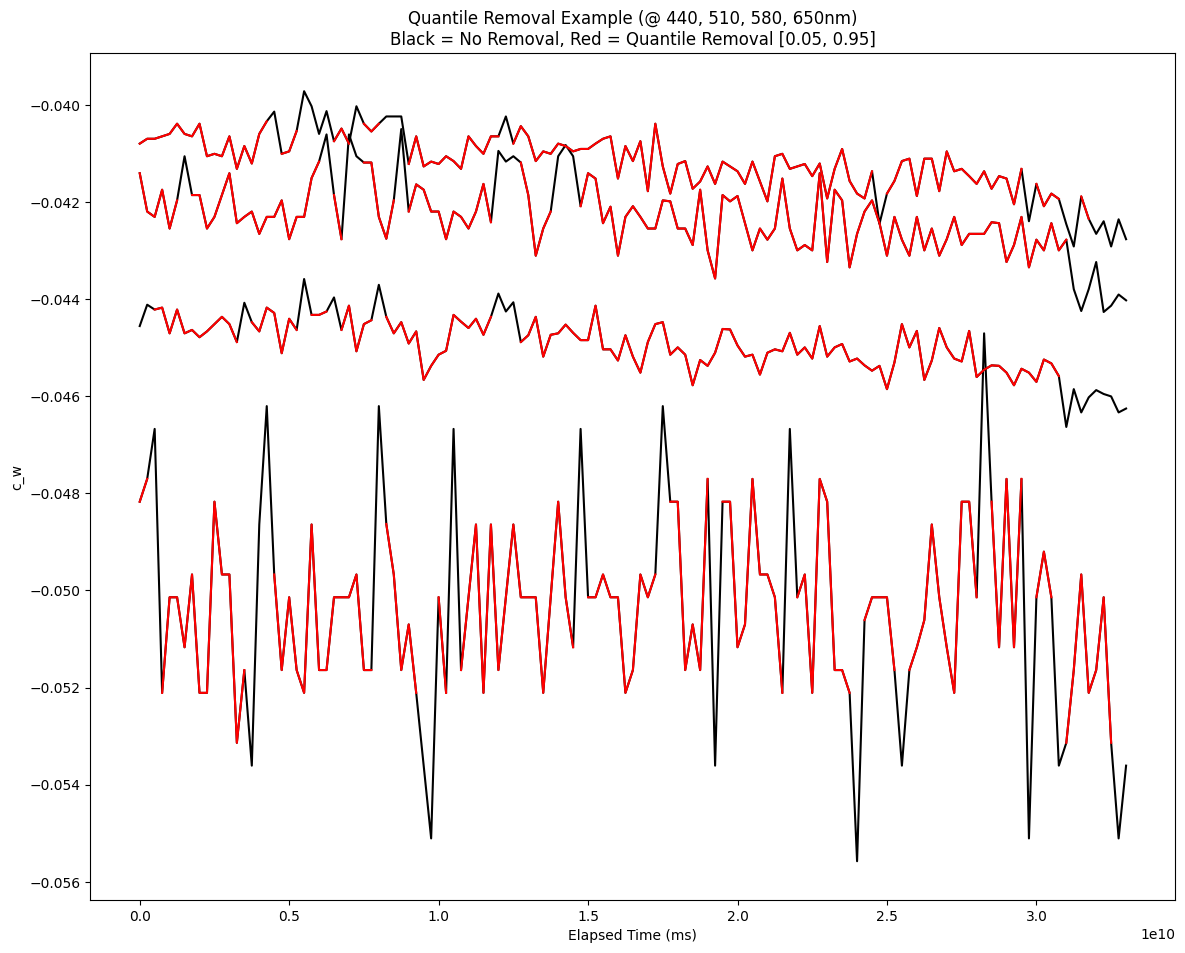

In [18]:
fig, ax = plt.subplots(1,1, figsize = (14,11))
ax.plot(c.elapsed_time, c.c_w, color = 'black')
ax.plot(cq.elapsed_time, cq.c_w, color = 'red')

ax.set_title('Quantile Removal Example (@ 440, 510, 580, 650nm)\nBlack = No Removal, Red = Quantile Removal [0.05, 0.95]')
ax.set_ylabel('c_w')
ax.set_xlabel('Elapsed Time (ms)')

Text(0.5, 0, 'Attenuation')

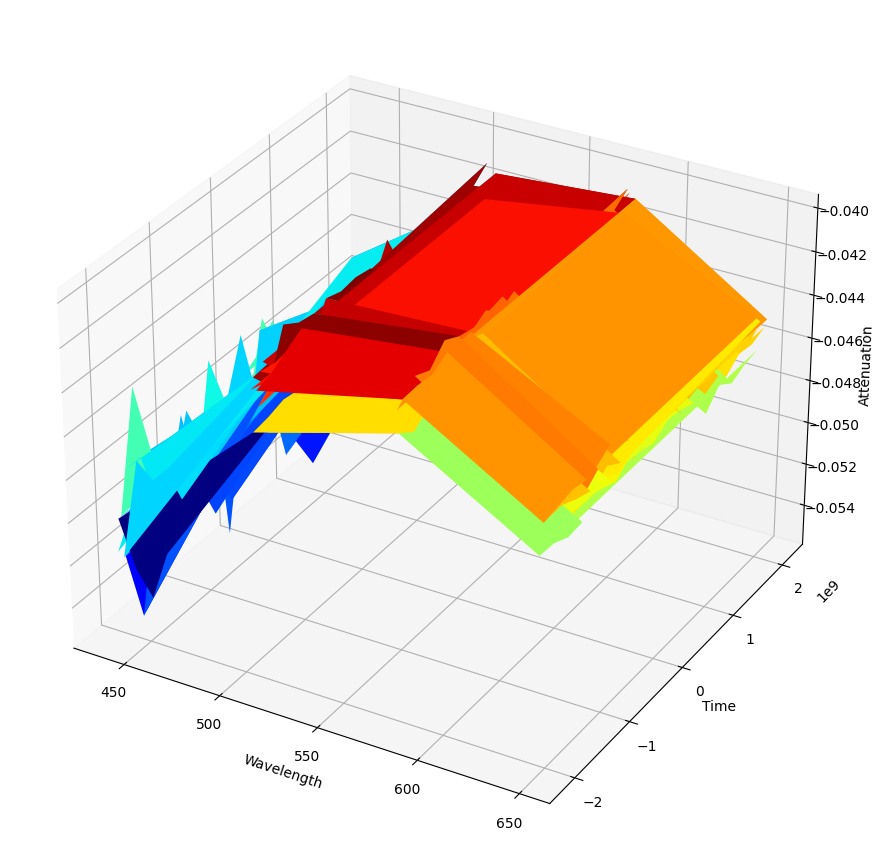

In [19]:
fig, ax = plt.subplots(1,1, figsize = (14,11), subplot_kw={'projection':'3d'})

x, y = np.meshgrid(c.wavelength_c,c.elapsed_time.astype(int))
z = c.c_w

surf = ax.plot_surface(x,y,z, cmap = 'jet', antialiased= True)
ax.set_xlabel('Wavelength')
ax.set_ylabel('Time')

ax.set_zlabel('Attenuation')